задание - https://docs.google.com/document/d/1CiqlkaiTJQfYpQKWTO72jo5kUJJ7wwSFyVV84-RkPw8/edit?usp=drive_web&ouid=115537759145523907268
данные - https://drive.google.com/drive/folders/19NUN0oT7Dacd83ua_ui9T3dS83v878YP

Мы владеем сетью магазинов, в которых продаются различные товары. Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине. Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж.

В результате работы должен получиться:
- Jupyter-ноутбук с моделью
- Признаки, влияющие больше всего на уровень продаж
- Датасет, если после ваших манипуляций он отличается от исходного;
- Документ с обоснованием решения и краткими результатами: какие техники и почему использовали, что получили, что можно улучшить (можно в рамках jupyter notebook’а)

In [387]:
from IPython.display import Image

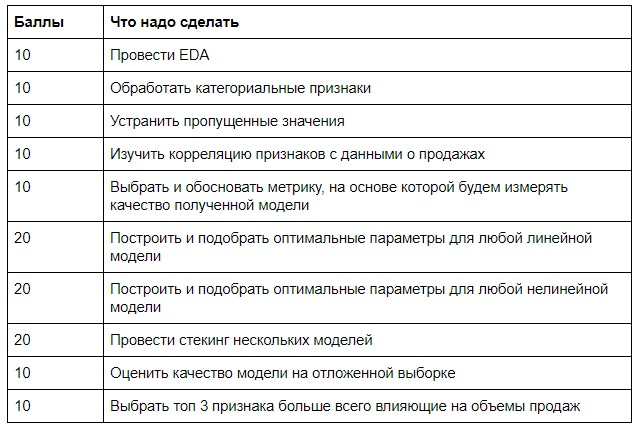

In [388]:
Image("task.jpg")

In [478]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [479]:
data = pd.read_csv('data.csv')

In [480]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [481]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Приведем к единому стандарту встречающиеся повторения в столбцах:

In [482]:
data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [483]:
#приводим к единому стандарту повторения
data['Item_Fat_Content'] = data['Item_Fat_Content'].map({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular',
                                                        'Low Fat': 'Low Fat', 'Regular': 'Regular'})

у нас всего 3 доступных варианта размера магазина, попробуем NaN заменить рандомно из имеющихся 3 значений

In [484]:
data['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [485]:
fill_list = ['Medium', 'High', 'Small']

In [486]:
data['Outlet_Size'] = data['Outlet_Size'].fillna(pd.Series(np.random.choice(fill_list, size=len(data.index))))

In [487]:
data['Outlet_Size'].unique()

array(['Medium', 'High', 'Small'], dtype=object)

#### Теперь идентифицируем категориальные признаки и пометим количественные:

In [488]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in df if f not in (cat_feat)]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = data[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

Item_Identifier         1559
Item_Fat_Content           2
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                3
Outlet_Location_Type       3
Outlet_Type                4
dtype: int64


#### Факторизируем категориальные признаки (кроме Item_Identifier), чтобы можно было продолжить EDA и визуализировать взаимосвязи:

In [489]:
df = data.copy()

In [490]:
df['Item_Fat_Content'] = pd.factorize(df['Item_Fat_Content'])[0]
df['Item_Type'] = pd.factorize(df['Item_Type'])[0]
df['Outlet_Identifier'] = pd.factorize(df['Outlet_Identifier'])[0]
df['Outlet_Size'] = pd.factorize(df['Outlet_Size'])[0]
df['Outlet_Location_Type'] = pd.factorize(df['Outlet_Location_Type'])[0]
df['Outlet_Type'] = pd.factorize(df['Outlet_Type'])[0]

#### Проведем EDA

In [491]:
statistics = df.describe()

In [492]:
mode = df.mode(axis = 0, dropna = True)

In [493]:
statistics.append(pd.Series(mode.iloc[0], name = 'mode'))

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,NaN
mean,12.857645,0.352693,0.066132,5.651062,140.992782,4.397161,1997.831867,0.957761,1.046580,0.692127,2181.288914,NaN
std,4.643456,0.477836,0.051598,3.669141,62.275067,2.785507,8.371760,0.890166,0.777719,1.060931,1706.499616,NaN
min,4.555000,0.000000,0.000000,0.000000,31.290000,0.000000,1985.000000,0.000000,0.000000,0.000000,33.290000,NaN
25%,8.773750,0.000000,0.026989,3.000000,93.826500,2.000000,1987.000000,0.000000,0.000000,0.000000,834.247400,NaN
50%,12.600000,0.000000,0.053931,5.000000,143.012800,4.000000,1999.000000,1.000000,1.000000,0.000000,1794.331000,NaN
75%,16.850000,1.000000,0.094585,7.000000,185.643700,7.000000,2004.000000,2.000000,2.000000,1.000000,3101.296400,NaN
max,21.350000,1.000000,0.328391,15.000000,266.888400,9.000000,2009.000000,2.000000,2.000000,3.000000,13086.964800,NaN
mode,12.150000,0.000000,0.000000,3.000000,172.042200,4.000000,1985.000000,0.000000,1.000000,0.000000,958.752000,FDG33


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


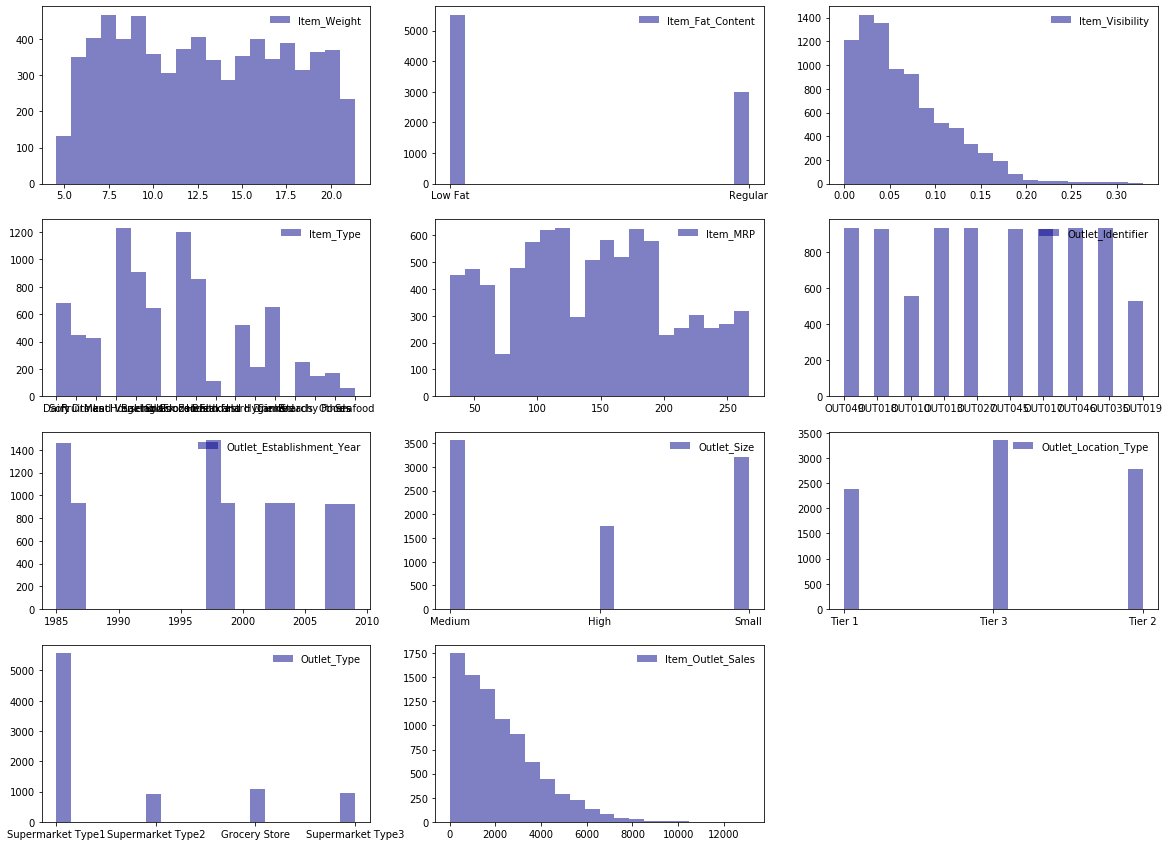

In [494]:
# сколько графиков в каждом ряду будет
ncols = 3
nrows = int(np.ceil(len(df.drop(['Item_Identifier'], axis = 1).columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))

# рисуем графики
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # рисуем только когда есть дата
        if counter < len(df.drop(['Item_Identifier'], axis = 1).columns):

            ax.hist(data[df.drop(['Item_Identifier'], axis = 1).columns[counter]], bins=20, color='darkblue', alpha=0.5, label='{}'.format(df.drop(['Item_Identifier'], axis = 1).columns[counter]))
            leg = ax.legend(loc='best')
            leg.draw_frame(False)

        # убрать оси, когда нет даты
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

Видим, что большинство данных сконцентрировано в Supermarket Type 1, при этом в основном магазины были открыты достаточно давно - большинство из них ранее 2000 года, при этом также большинство магазинов находятся лишь в Tier 3 локации.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


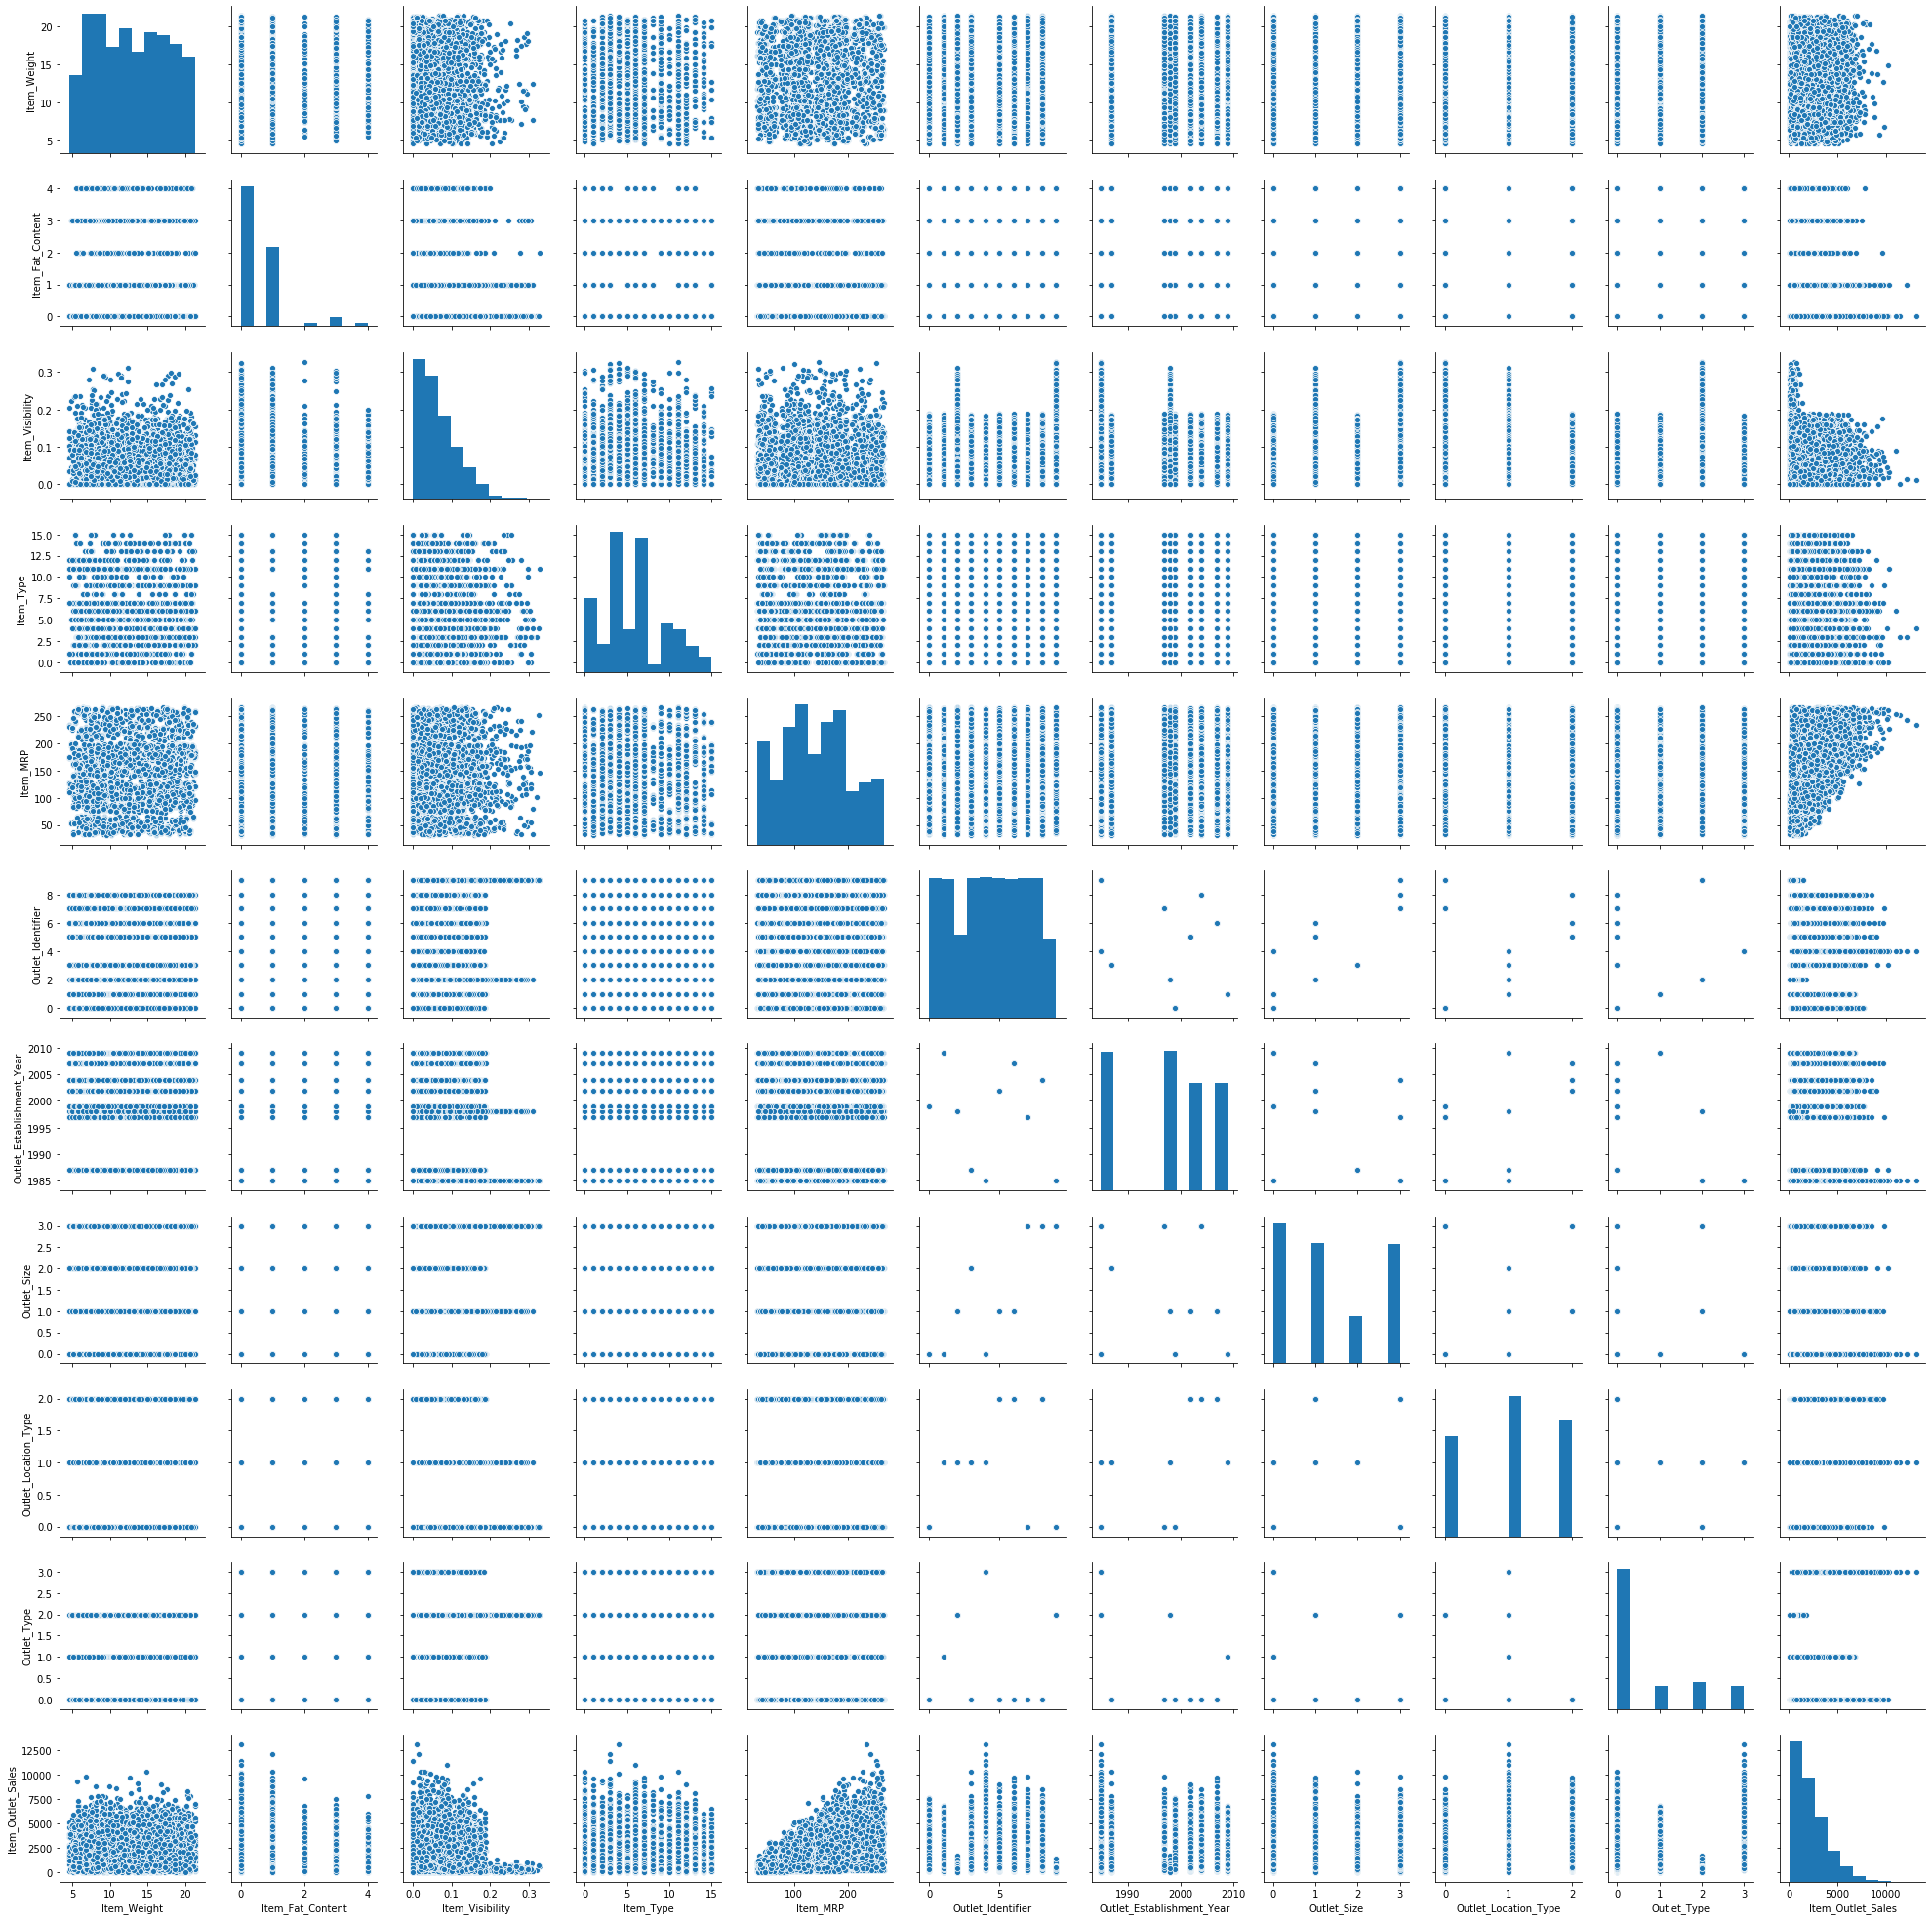

In [424]:
sns.pairplot(df)

Корреляционная матрица исходной таблицы:


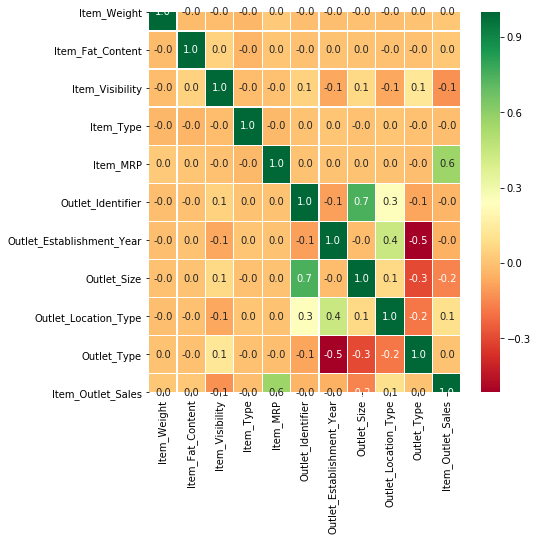

In [495]:
import seaborn as sns
print('Корреляционная матрица исходной таблицы:')
sns.heatmap(df.drop(['Item_Identifier'], axis = 1).corr(),annot=True, fmt = '.1f',cmap='RdYlGn', linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(7,7)
plt.show()

Определенно взаимосвязь прослеживается между продажами и ценой продукта (Item_MRP), также отрицательная корреляция имеется между продажами и размером магазина (Outlet_Size). Небольшую корреляция также наблюдается между продажами и локацией магазина (Outlet_Location_Type).

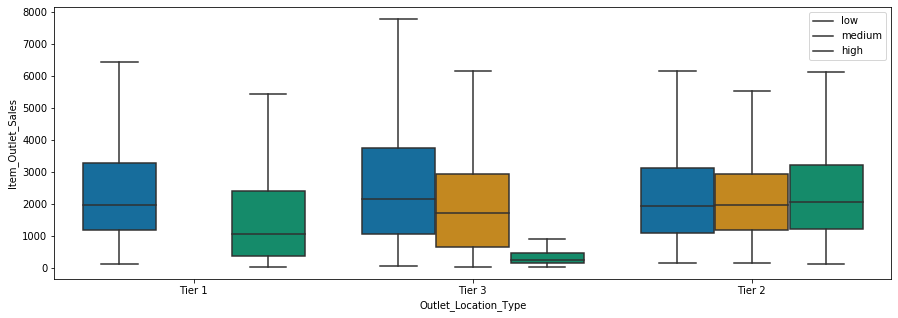

In [559]:
plt.figure(figsize=(15,5))
sns.boxplot(y=df['Item_Outlet_Sales'], 
            x=data['Outlet_Location_Type'], 
            hue=data['Outlet_Size'],
            palette="colorblind", showfliers=False)
plt.legend(['low', 'medium', 'high'])

Как видно, локация и размеры магазина действительно не на столько драматично влияют на уровень продаж - т.к. медиана у всех boxplot +/- на одном уровне , хотя наибольший разброс наблюдается в маленьких магазинах (small) и особенно в локации Tier 3

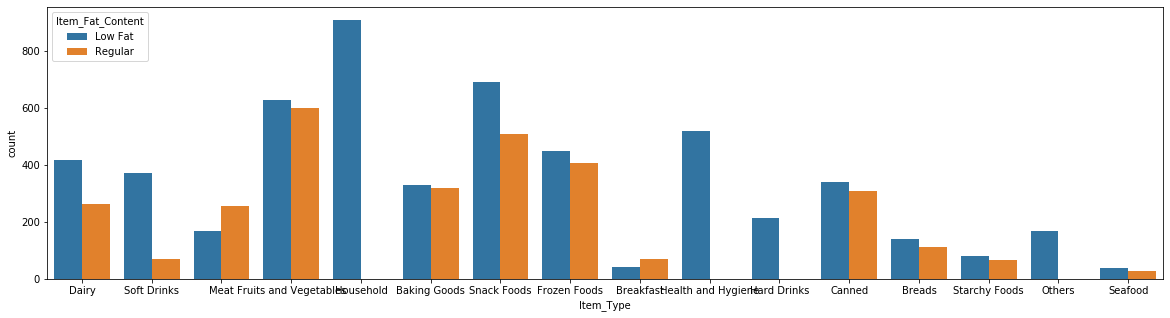

In [529]:
plt.figure(figsize=(20,5))
sns.countplot(x="Item_Type", hue="Item_Fat_Content", data=data)

Как видно, большинство продуков встречаются одинаково как в категории low fat , так и regular. Исходя из этого, возможно, процент жира в продукте не должен так сильно влиять на уровень продаж

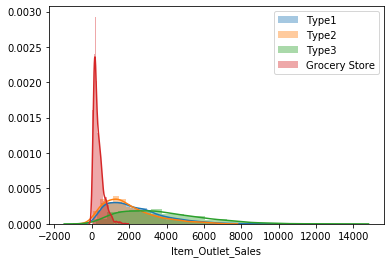

In [536]:
sns.distplot(data[data['Outlet_Type'] == 'Supermarket Type1']['Item_Outlet_Sales'])
sns.distplot(data[data['Outlet_Type'] == 'Supermarket Type2']['Item_Outlet_Sales'])
sns.distplot(data[data['Outlet_Type'] == 'Supermarket Type3']['Item_Outlet_Sales'])
sns.distplot(data[data['Outlet_Type'] == 'Grocery Store']['Item_Outlet_Sales'])
plt.legend(['Type1', 'Type2', 'Type3', 'Grocery Store'])

Действительно, распределения среди различного типа магазинов сильно отличаются друг от друга: сильно выделяется Grocery Store - в основном недорогие покупки

In [496]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(data[cat_feat], columns=cat_feat)
dummy_cols = list(set(dummy_train))
dummy_train = dummy_train[dummy_cols]

In [497]:
from sklearn.preprocessing import StandardScaler

train_median = df[num_feat].median()

X_train_lin = pd.concat([df[num_feat].fillna(train_median),
                     df[cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])

In [498]:
X_train_lin.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_NaN,Item_Type_NaN,Outlet_Identifier_NaN,Outlet_Size_NaN,Outlet_Location_Type_NaN,...,Outlet_Identifier_OUT027,Item_Fat_Content_Regular,Outlet_Type_Supermarket Type2,Outlet_Location_Type_Tier 2,Outlet_Identifier_OUT035,Item_Type_Soft Drinks,Item_Type_Others,Outlet_Identifier_OUT049,Item_Fat_Content_Low Fat,Item_Type_Health and Hygiene
0,-0.831187,-0.970732,1.747454,0.139541,0.910601,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,-1.630810,-0.908111,-1.489023,1.334103,-1.018440,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
2,1.108727,-0.956917,0.010040,0.139541,-0.049238,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1.510904,-1.281758,0.660050,0.020085,-0.849103,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,-0.918719,-1.281758,-1.399220,-1.293934,-0.695373,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Строим линейную модель:

Поскольку перед нами стоит задача регрессии, то предпочтительнее использовать метрики MAE или MSE, т.к. нам необходимо понять насколько сильно ошибка наших предсказаний по сравнению с действительностью. Сконцентруемся на метрике RMSE, а также будет считать точность модели. Чем выше точность - тем лучше. Тем ниже RMSE - тем лучше.

In [499]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [500]:
X = X_train_lin.drop(['Item_Outlet_Sales'], axis = 1)
y = X_train_lin['Item_Outlet_Sales']

In [501]:
lin_reg = LinearRegression()

In [502]:
cv_scores = cross_val_score(lin_reg, X, y, cv = 5)
rmse_cv = np.sqrt(-cross_val_score(lin_reg, X, y,  scoring="neg_mean_squared_error", cv = 5))

In [503]:
print("Mean 5-Fold CV Score: {}".format(np.mean(cv_scores)))
print("Root Mean Squared Error: {}".format(np.mean(rmse_cv)))

Mean 5-Fold CV Score: 0.5577324735056124
Root Mean Squared Error: 0.6646242835676633


#### Попробуем GridSearch c Ridge регрессией:

In [504]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [505]:
ridge = Ridge()

In [506]:
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

In [507]:
ridge_reg = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 5)

In [508]:
ridge_reg.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [509]:
print(ridge_reg.best_params_)

{'alpha': 20}


In [510]:
ridge_best = Ridge(alpha = 20)

In [511]:
cv_scores_ridge = cross_val_score(ridge_best, X, y, cv = 5)
rmse_cv_ridge = np.sqrt(-cross_val_score(ridge_best, X, y,  scoring="neg_mean_squared_error", cv = 5))

In [512]:
print("Ridge Regression R^2: {}".format(np.mean(cv_scores_ridge)))
print("Root Mean Squared Error: {}".format(np.mean(rmse_cv_ridge)))

Ridge Regression R^2: 0.5589880051148657
Root Mean Squared Error: 0.663702840668193


#### Пробуем нелинейную модель:

In [513]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [514]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [515]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [516]:
print("Gradiet Boosting Regression R^2: {}".format(reg.score(X_test, y_test)))
rmse_grad = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
print("Root Mean Squared Error: {}".format(rmse_grad))

Gradiet Boosting Regression R^2: 0.5930146278299173
Root Mean Squared Error: 0.6436665974089005


Данная модель действительно показывает чуть лучше результат

Text(0.5, 1.0, '10 Most Important Features')

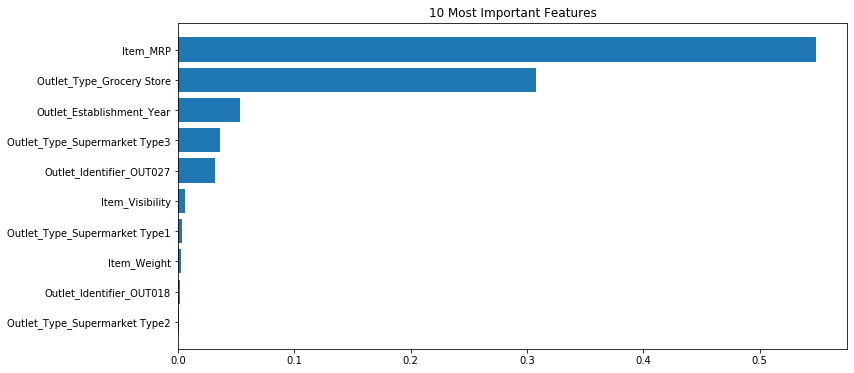

In [517]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(X.columns))[sorted_idx])
plt.title('10 Most Important Features')

Как видно, действительно, цена и тип магазина grocery_store являются доминирующими переменными в предсказании объема продаж